In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np

from dataset import get_dataset
from logger import Logger
from core.models import get_model
from core import solver_dict
from init import get_cfg, setup_seed, dev_get_cfg

# preparer configuration
cfg  =dev_get_cfg()

device = "cuda:0"

# set random seed
setup_seed(cfg["rand_seed"])

# prepare dataset
DatasetClass = get_dataset(cfg)
datasets_dict = dict()
for mode in cfg["modes"]:
    datasets_dict[mode] = DatasetClass(cfg, mode=mode)

# prepare models
ModelClass = get_model(cfg["model"]["model_name"])
model = ModelClass(cfg)

# prepare logger
logger = Logger(cfg)

# register dataset, models, logger to the solver
solver = solver_dict[cfg["runner"].lower()](cfg, model, datasets_dict, logger)

| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:20 | Set GPU: 0 ...   [post_config.py:99]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:20 | Save configuration to local file...   [post_config.py:105]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:20 | Dataset train with 100.0% data, dataset len is 149, total len is 149   [shapenet_new2.py:203]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:20 | Caching train dataset...   [shapenet_new2.py:231]


Please check the configuration
--------------------------------------------------------------------------------
{'dataset': {'aug_ratio': 0.7,
             'categories': ['03797390'],
             'data_root': '../data/ShapeNetV1_SDF',
             'dataset_name': 'shapenet_new2',
             'dataset_proportion': [1.0, 1.0],
             'dataset_root': 'resource/data/XXXX',
             'dep_max_use_view': 12,
             'dep_min_use_view': 4,
             'dep_total_view': 12,
             'depth_postfix': '_dep_small',
             'field_mode': 'sdf',
             'indices': {'test_index': 'None',
                         'train_index': 'None',
                         'val_index': 'None'},
             'input_mode': 'dep',
             'n_pcl': 512,
             'n_query_eval': 10000,
             'n_query_nss': 1024,
             'n_query_uni': 1024,
             'noise_std': 0.01,
             'num_workers': 8,
             'pin_mem': True,
             'ram_cache': True,
  

100%|██████████| 149/149 [00:04<00:00, 36.84it/s]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:24 | Dataset val with 100.0% data, dataset len is 22, total len is 22   [shapenet_new2.py:203]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:24 | Caching val dataset...   [shapenet_new2.py:231]
100%|██████████| 22/22 [00:00<00:00, 37.76it/s]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:25 | DGCNN use Dynamic Graph (different from the input topology)   [vec_dgcnn_atten.py:50]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:25 | 2.016M params in encoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-11-13:28:25 | 0.790M params in decoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | WARNING | Dec-11-13:28:25 | Network Components != Optimizer Config   [model_base.py:31]


In [2]:
ckpt_path = f"/home/ziran/se3/EFEM/lib_shape_prior/log/12_10_shape_prior_mugs_old/12_10_shape_prior_mugs_FOR_hopefullybetterAE/checkpoint/15409.pt"
# ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/selected.pt"
ckpt = torch.load(ckpt_path)


# 注意不是model.load_state_dict,
# 参见 lib_shape_prior/core/solver_v2.py, lib_shape_prior/core/models/model_base.py

model.network.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [3]:
train_ds = datasets_dict['train']

train_ds[0][0].keys(), train_ds[0][1].keys()

import torch
from torch.utils.data import DataLoader

# 假设你的Dataset实例叫做 train_ds
# 设置DataLoader参数
batch_size = 10  # 根据你的GPU内存调整
shuffle = True  # 如果你想每个epoch都打乱数据
num_workers = 4  # 根据你的CPU情况调整

# 创建DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


In [4]:
type(model.network.network_dict["encoder"])

core.lib.vec_sim3.vec_dgcnn_atten.VecDGCNN_att

In [5]:
for batch_idx, (data, meta) in enumerate(train_loader):
    print(data['inputs'].to(dtype=torch.float32).shape)
    break

torch.Size([10, 512, 3])


In [6]:
# 假设你的autoencoder模型名为autoencoder，并且它已经被正确地加载了权重
autoencoder = model.network.network_dict["encoder"].to(device)
autoencoder.eval()  # 设置为评估模式

# 为所有的shape codes初始化空的列表
ids = []
z_so3s = []
z_invs = []
centers = []
scales = []
z_so3_projs = []
z_so3_bases = []
z_so3_vars = []
bboxes = []
bbox_cs = []
pcls = []
clss = []



# 遍历DataLoader
with torch.no_grad():  # 不计算梯度
    for batch_idx, (data, meta) in enumerate(train_loader):
        # data['inputs']应该包含点云数据
        input_pcl = data['inputs'].to(dtype=torch.float32).transpose(2, 1).to(device)  # 把数据移到GPU上，如果你在用GPU
        centroid = input_pcl.mean(-1)  # B,3
        input_pcl = input_pcl - centroid[..., None]

        
        # query = torch.cat([data["points.uni"], data["points.nss"]], dim=1)
        # B, _, N = input_pcl.shape

        # 通过encoder获取latent codes
        center, scale, z_so3, out_inv_feat = model.network.network_dict["encoder"](input_pcl)



        # 收集所有需要的codes
        ids.append(meta['internal_idx'])
        z_so3s.append(z_so3.detach())
        z_invs.append(out_inv_feat.detach())
        centers.append(center.detach())
        scales.append(scale.detach())
        # ... 这里你需要填充剩下的latent codes的获取方法

        # 收集bbox和pcl等数据
        bboxes.append(data['bbox'])
        pcls.append(data['points.uni.value'])
        clss.append(meta['cls'])
        
        # 如果你的模型返回的不是z_so3_proj, z_so3_basis等，你需要相应地计算它们
        # 例如:
        # z_so3_proj = compute_projection(z_so3)  # 你需要定义这个函数
        # z_so3_bases = compute_bases(z_so3)      # 你需要定义这个函数
        # ...

        # 用预定义的函数或方法获取或计算剩余的codes
        # 请确保这些函数已经定义，并能根据你的模型的输出给出正确的结果
        # z_so3_projs.append(z_so3_proj)
        # z_so3_bases.append(z_so3_basis)
        # z_so3_vars.append(z_so3_var)
        # ...



In [7]:

    
# 最后，将所有收集到的列表转换为Tensor
id = torch.cat(ids, dim=0)
z_so3 = torch.cat(z_so3s, dim=0)
z_inv = torch.cat(z_invs, dim=0)
center = torch.cat(centers, dim=0)
scale = torch.cat(scales, dim=0)
# ... 对于其它的shape codes也做相同的事情
bbox_c = torch.cat(bboxes, dim=0)
pcl = torch.cat(pcls, dim=0)
cls = torch.cat(clss, dim=0)

codebook = {
    'ids': id,
    'z_so3': z_so3,
    'z_inv': z_inv,
    'center': center,
    'scale': scale,
    # ... 对于其它的shape codes也做相同的事情
    'bbox_c': bbox_c,
    'pcl': pcl,
    'cls': cls,
    'id': 0,
}

In [8]:
codebook['scale']

tensor([1.3686, 0.8971, 1.0194, 0.9119, 1.0632, 0.9680, 0.8998, 1.4310, 1.3896,
        0.9751, 1.0531, 1.4047, 1.0048, 1.1450, 1.2175, 1.0712, 1.0467, 1.3778,
        1.1651, 0.9777, 1.0142, 1.2344, 1.3479, 1.4022, 1.3100, 1.2511, 1.0581,
        1.2820, 1.2300, 0.9723, 1.1705, 1.5545, 1.0263, 0.8731, 1.0670, 0.9584,
        1.6206, 1.0682, 1.3069, 1.0315, 1.1620, 1.0765, 1.0785, 1.3391, 0.9952,
        1.0226, 1.0934, 1.4123, 0.8880, 1.1509, 0.9962, 1.0864, 1.2239, 0.9991,
        1.1631, 0.9869, 1.0234, 1.5119, 0.9190, 1.0304, 1.3412, 0.9146, 1.2617,
        1.1591, 1.2459, 0.9246, 1.0178, 1.1098, 0.9299, 0.9912, 1.2920, 1.1406,
        0.9037, 0.9645, 1.6934, 0.9955, 0.9761, 1.0938, 0.9567, 1.1824, 0.9065,
        1.0723, 1.0286, 0.9821, 1.0380, 1.2257, 1.1417, 0.9752, 0.9782, 1.1009,
        1.5262, 1.2876, 0.9688, 1.1909, 1.1340, 1.0454, 1.3705, 1.1421, 1.3771,
        1.0006, 1.1253, 1.0410, 0.9214, 1.1628, 1.2734, 1.6375, 0.9767, 0.9799,
        1.1507, 1.2426, 1.2444, 1.0445, 

In [9]:
import numpy as np
# save codebook to local
# codebook_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/codebook.npz"
codebook_path = f"/home/ziran/se3/EFEM/lib_shape_prior/log/12_10_shape_prior_mugs_old/12_10_shape_prior_mugs_FOR_hopefullybetterAE/codebook.npz"

for k, v in codebook.items():
    if isinstance(v, torch.Tensor):
        codebook[k] = v.cpu().numpy()
# save the codebook as npz file
np.savez(codebook_path, **codebook)



with np.load(codebook_path) as data:
    # 将 npz 文件内容转换为字典
    codebook = {key: data[key] for key in data}

for k, v in codebook.items():
    if isinstance(v, np.ndarray):
        newv = torch.from_numpy(v)
        codebook[k] = newv
    print(k, v.shape)

ids (149,)
z_so3 (149, 256, 3)
z_inv (149, 256)
center (149, 1, 3)
scale (149,)
bbox_c (149, 3)
pcl (149, 1024)
cls (149,)
id ()


In [10]:
bs = 3
pred_so3_feat = codebook['z_so3'][:bs]
pred_inv_feat = codebook['z_inv'][:bs]
pred_scale = codebook['scale'][:bs]
pred_scale = torch.ones_like(pred_scale) + 0.2
pred_center = codebook['center'][:bs]
pred_center = torch.zeros_like(pred_center)
# 上面两个注释掉的, 如果用默认0和1的center和scale, 会导致decode不太行, 还是用codebook里的比较好
# 于是那就应该把这四个variable一块diffusion

pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
pred_scale = torch.tensor(pred_scale).float().to(device)
pred_center = torch.tensor(pred_center).float().to(device)

/tmp/ipykernel_2003800/4186585311.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
/tmp/ipykernel_2003800/4186585311.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
/tmp/ipykernel_2003800/4186585311.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_scale = torch.tensor(pred_scale).float().to(device)
/tmp/ipykernel_2003800/4186585311.py:14: UserWarning: To copy construct from a tensor, it is recomme

In [11]:
feat = torch.cat([pred_so3_feat, 
                  pred_inv_feat.unsqueeze(2), 
                  pred_scale.unsqueeze(1).unsqueeze(1).repeat(1,256,1), 
                  pred_center.repeat(1,256,1)], dim=2)
feat.shape

torch.Size([3, 256, 8])

In [12]:
device = "cuda:0"

N = 64

space_dim = [N, N, N]  # 示例为一个50x50x50的网格


di = 1
# 创建一个网格，这里我们使用np.linspace来产生线性间隔的点
x = np.linspace(-di, di, space_dim[0])
y = np.linspace(-di, di, space_dim[1])
z = np.linspace(-di, di, space_dim[2])

# 用np.meshgrid得到每个维度的点阵
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# 将这些点整理成query的形式，每行是一个点的坐标
query = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)
query

array([[-1.        , -1.        , -1.        ],
       [-1.        , -1.        , -0.96825397],
       [-1.        , -1.        , -0.93650794],
       ...,
       [ 1.        ,  1.        ,  0.93650794],
       [ 1.        ,  1.        ,  0.96825397],
       [ 1.        ,  1.        ,  1.        ]])

In [13]:

query = torch.tensor(query,dtype=torch.float32).to(device)
query = query.repeat(bs, 1, 1)
query.shape

torch.Size([3, 262144, 3])

In [14]:
embedding = {
            "z_so3": pred_so3_feat, # [B, 256, 3]
            "z_inv": pred_inv_feat, # [B, 256]
            "s": pred_scale, # [B]
            # "t": centroid.unsqueeze(1), # [B, 1, 3]
            "t": pred_center, # [B, 1, 3]
        }

sdf_hat = model.network.decode(  # SDF must have nss sampling
            query,
            None,
            embedding,
            return_sdf=True,
        )

In [15]:
sdf_grid = sdf_hat.reshape(-1, space_dim[0], space_dim[1], space_dim[2]).to("cpu").detach().numpy()
data = sdf_grid[2]

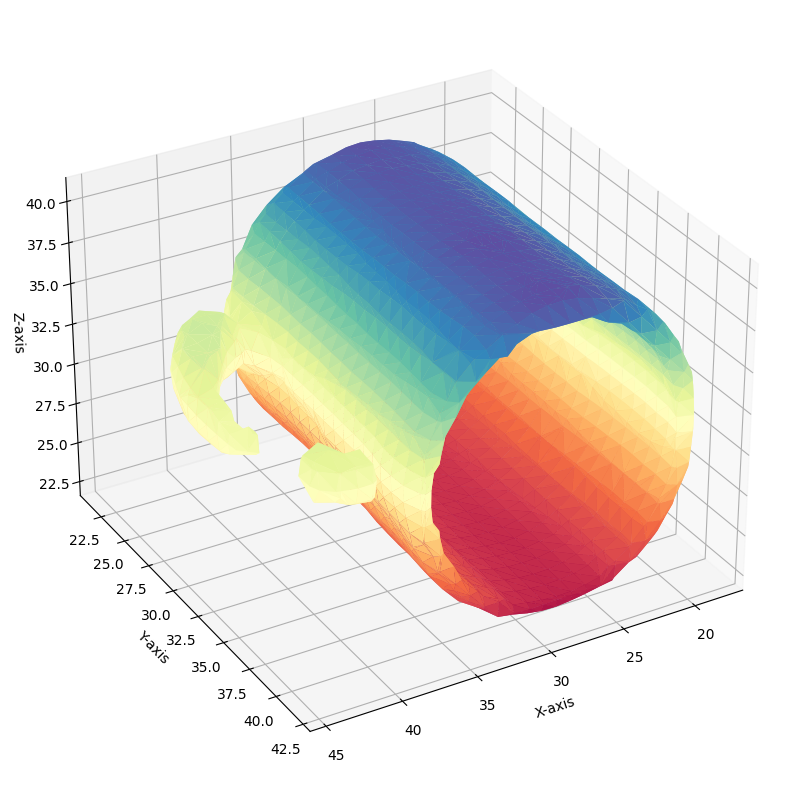

In [16]:
%matplotlib inline
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 使用 Marching Cubes 算法提取等值面
verts, faces, normals, values = measure.marching_cubes(data, level=0.)

# 创建一个新的图形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制等值面
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)

# 设置图形的视角和轴标签
ax.view_init(30, 60)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义一个简单的全连接网络模型
class LatentDiffusionModel(nn.Module):
    def __init__(self, latent_dim, hidden_dims):
        super(LatentDiffusionModel, self).__init__()
        layers = []
        input_dim = latent_dim[0] * latent_dim[1]  # 256 * 8 in your case

        # 构建网络层
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            input_dim = hidden_dim  # Set input dim for next layer

        # 最后一层输出与输入维度相同
        layers.append(nn.Linear(input_dim, latent_dim[0] * latent_dim[1]))

        # 将所有层放入Sequential中
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        # Flatten the input
        x = x.view(batch_size, -1)
        # Pass through the model
        x = self.model(x)
        # Reshape the output to the original shape
        return x.view(batch_size, *latent_dim)

# 模型的潜在维度和隐藏层维度
latent_dim = (256, 8)
hidden_dims = [512, 256, 512]  # Example of hidden dimensions

# 初始化模型
diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims)

# 查看模型结构
diffusion_model

# 注意：这里的模型仅用于展示，没有准备好训练数据和训练过程。


In [ ]:
a = torch.rand(1, 256, 8)
a.shape
out = diffusion_model(a)
out.shape